In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download rahmatrizalwan/kitchen-set-dataset-spoon-knife-fork
!mkdir kitchen

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip /content/kitchen/archive.zip -d /content/kitchen

Archive:  /content/kitchen/archive.zip
  inflating: /content/kitchen/Fork Dataset/ímgfork (1).jpg  
  inflating: /content/kitchen/Fork Dataset/ímgfork (10).jpg  
  inflating: /content/kitchen/Fork Dataset/ímgfork (100).jpg  
  inflating: /content/kitchen/Fork Dataset/ímgfork (11).jpg  
  inflating: /content/kitchen/Fork Dataset/ímgfork (12).jpg  
  inflating: /content/kitchen/Fork Dataset/ímgfork (13).jpg  
  inflating: /content/kitchen/Fork Dataset/ímgfork (14).jpg  
  inflating: /content/kitchen/Fork Dataset/ímgfork (15).jpg  
  inflating: /content/kitchen/Fork Dataset/ímgfork (16).jpg  
  inflating: /content/kitchen/Fork Dataset/ímgfork (17).jpg  
  inflating: /content/kitchen/Fork Dataset/ímgfork (18).jpg  
  inflating: /content/kitchen/Fork Dataset/ímgfork (19).jpg  
  inflating: /content/kitchen/Fork Dataset/ímgfork (2).jpg  
  inflating: /content/kitchen/Fork Dataset/ímgfork (20).jpg  
  inflating: /content/kitchen/Fork Dataset/ímgfork (21).jpg  
  inflating: /content/kitchen/Fo

In [ ]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

In [ ]:
dataset_path = Path(r'/content/kitchen')
file_path = list(dataset_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [ ]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)
df = pd.concat([file_path, labels], axis=1)
df.columns = ['image', 'label']
df.head()

,image,label
0,/content/kitchen/Spoon Dataset/imgspoon (11).jpg,Spoon Dataset
1,/content/kitchen/Spoon Dataset/imgspoon (67).jpg,Spoon Dataset
2,/content/kitchen/Spoon Dataset/imgspoon (72).jpg,Spoon Dataset
3,/content/kitchen/Spoon Dataset/imgspoon (33).jpg,Spoon Dataset
4,/content/kitchen/Spoon Dataset/imgspoon (14).jpg,Spoon Dataset


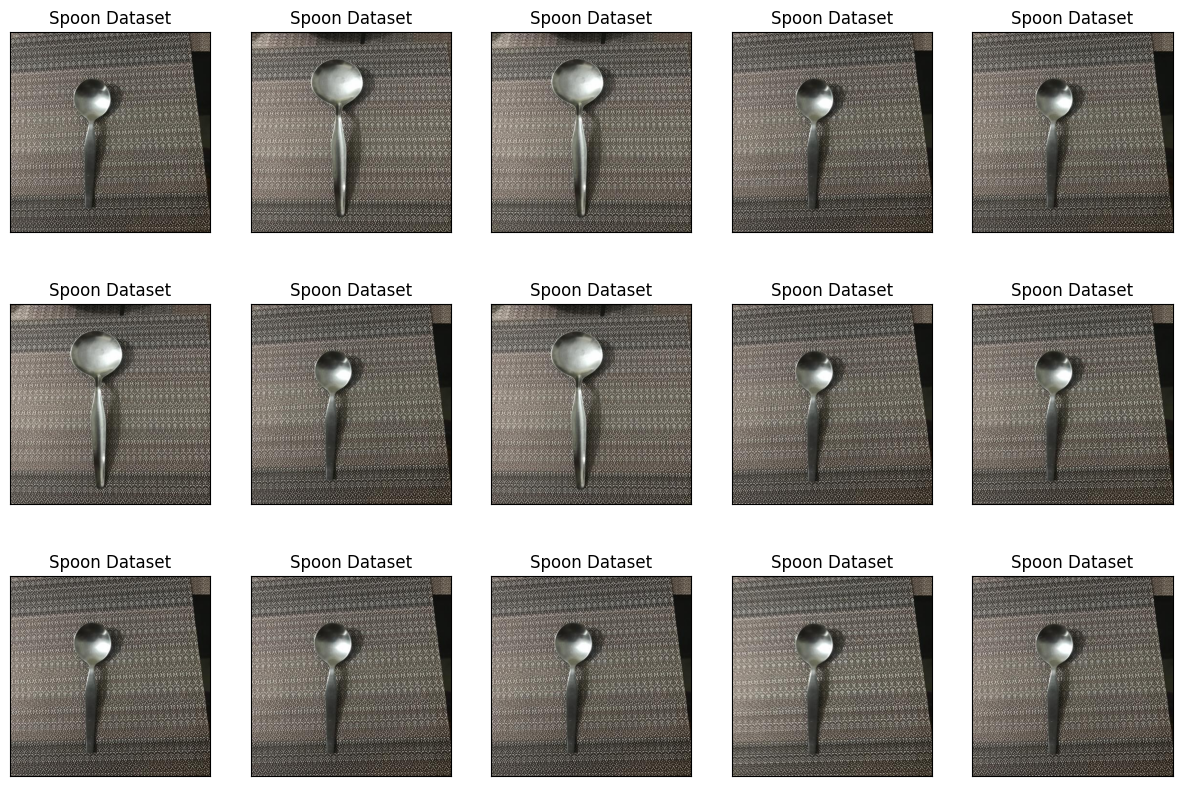

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [ ]:
df.label.value_counts()

Spoon Dataset     100
Kniife Dataset    100
Fork Dataset      100
Name: label, dtype: int64

In [ ]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

Spoon Dataset     100
Kniife Dataset    100
Fork Dataset      100
Name: label, dtype: int64

In [ ]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [ ]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (168, 2)
Shape of test data (90, 2)
Shape of validation data (42, 2)


In [ ]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 168 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.
Found 42 validated image filenames belonging to 3 classes.


In [ ]:
input_shape = (200, 200, 3)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [ ]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train, batch_size= 512, validation_data=val, epochs=100, callbacks=callback)

Epoch 1/100
6/6 [==============================] - 17s 550ms/step - loss: 1.1135 - accuracy: 0.3452 - val_loss: 1.0444 - val_accuracy: 0.3810
Epoch 2/100
6/6 [==============================] - 2s 412ms/step - loss: 1.0345 - accuracy: 0.3690 - val_loss: 0.9876 - val_accuracy: 0.3810
Epoch 3/100
6/6 [==============================] - 3s 610ms/step - loss: 0.9654 - accuracy: 0.5774 - val_loss: 0.9187 - val_accuracy: 0.5476
Epoch 4/100
6/6 [==============================] - 2s 411ms/step - loss: 0.7828 - accuracy: 0.6429 - val_loss: 0.8351 - val_accuracy: 0.5476
Epoch 5/100
6/6 [==============================] - 3s 418ms/step - loss: 0.5833 - accuracy: 0.8095 - val_loss: 0.6427 - val_accuracy: 0.6667
Epoch 6/100
6/6 [==============================] - 3s 421ms/step - loss: 0.4520 - accuracy: 0.8512 - val_loss: 0.7708 - val_accuracy: 0.7143
Epoch 7/100
6/6 [==============================] - 3s 578ms/step - loss: 0.3763 - accuracy: 0.8631 - val_loss: 0.5256 - val_accuracy: 0.7381
Epoch 8/100


In [ ]:
model.save('model-1.h5')

In [ ]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

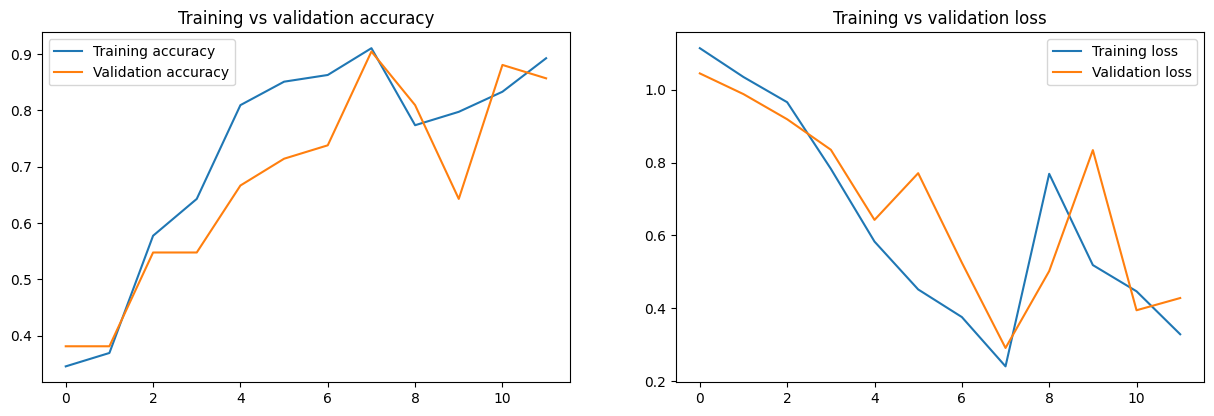

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")
plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")
plt.show()

In [ ]:
pred = model.predict(test)

3/3 [==============================] - 2s 557ms/step


In [ ]:
pred = np.argmax(pred, axis=1)

In [ ]:
labels = train.class_indices

In [ ]:
labels

{'Fork Dataset': 0, 'Kniife Dataset': 1, 'Spoon Dataset': 2}

In [ ]:
labels = dict((v,k) for k, v in labels.items())

In [ ]:
labels

{0: 'Fork Dataset', 1: 'Kniife Dataset', 2: 'Spoon Dataset'}

In [ ]:
y_pred = [labels[k] for k in pred]

In [ ]:
print(classification_report(x_test.label, y_pred))

                precision    recall  f1-score   support

  Fork Dataset       0.88      0.96      0.92        24
Kniife Dataset       0.97      0.97      0.97        33
 Spoon Dataset       0.97      0.91      0.94        33

      accuracy                           0.94        90
     macro avg       0.94      0.95      0.94        90
  weighted avg       0.95      0.94      0.94        90



In [ ]:
print(confusion_matrix(x_test.label, y_pred))

[[23  1  0]
 [ 0 32  1]
 [ 3  0 30]]


In [ ]:
test_accuracy = model.evaluate(test)[1]

3/3 [==============================] - 1s 340ms/step - loss: 0.2599 - accuracy: 0.9556
